<a href="https://colab.research.google.com/github/MaschinenNah/MachineLearningKochbuch02_Generatoren/blob/main/03_BilderLaden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ein Generator, der Bilddateien lädt

In [9]:
!git clone https://github.com/MaschinenNah/ml_utils
from ml_utils import load
from ml_utils import show

fatal: destination path 'ml_utils' already exists and is not an empty directory.


In [2]:
zip_url = "http://pitnoack.de/mn/generator_bilder_laden/data.zip"
load.load_and_unzip_from_url(zip_url)

### Die Definition des Generators.

Der Einfachheit halber haben wir einen Generator konstruiert, dessen Ausgaben für x und y identisch sind. Dieser könnte zum Training eines [Autoencoders](https://de.wikipedia.org/wiki/Autoencoder) genutzt werden.

In [3]:
from tensorflow.keras.utils import Sequence
import numpy as np
from PIL import Image
import os
import random

class ImageGenerator(Sequence):

  # Der Konstruktor erwartet hier:
  # dir_ = Das Verzeichnis mit den Bilddateien
  # shape = Die shape eines Bildes
  # batch_size = Umfang eines Batches.
  def __init__(self, dir_, shape, batch_size=25):
    # Die Pfade zu allen Bilddateien...
    self.file_paths = load.all_abs_paths_in_dir(dir_)
    self.len = int(len(self.file_paths)/batch_size)
    self.shape = shape
    self.batch_size = batch_size
    
    # Einmal mischen....
    random.shuffle(self.file_paths)

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    if index >= self.len:
      raise IndexError("list index out of range")
    else:
      # Die zum Batch gehörenden Pfade werden ermittelt:
      file_paths = self.file_paths[index*self.batch_size:(index+1)*self.batch_size]
      # Ein leeres NumPy Array, das den Batch speichert.
      batch_x = np.empty((self.batch_size,) + (self.shape), "float32")
      for idx, file_path in enumerate(file_paths):
        # lädt das Bild aus dem Pfad in ein numpy Array:
        img_as_array = load.img_path_to_np_array(file_path)
        # Befüllung des Batches...
        batch_x[idx] = img_as_array
      return batch_x, batch_x

Hier erzeugen wir einen Generator durch Konstruktoraufruf.

In [4]:
train_dir = "/content/data/img_train"

# (48, 48, 3) entspricht der shape der im train_dir gespeicherten Bilder.
# Andernfalls würde es einen Fehler geben:
train_gen = ImageGenerator(train_dir, (48, 48, 3))

`train_gen[0]` ist ein Batch:

In [5]:
batch = train_gen[0]

Ein Batch ist (wie immer) ein Tupel:

In [6]:
type(batch)

tuple

`batch[0]` ist der x-Anteil und `batch[1]` der y-Anteil. Die shape ist entsprechend:

In [7]:
print(batch[0].shape)
print(batch[1].shape)

(25, 48, 48, 3)
(25, 48, 48, 3)


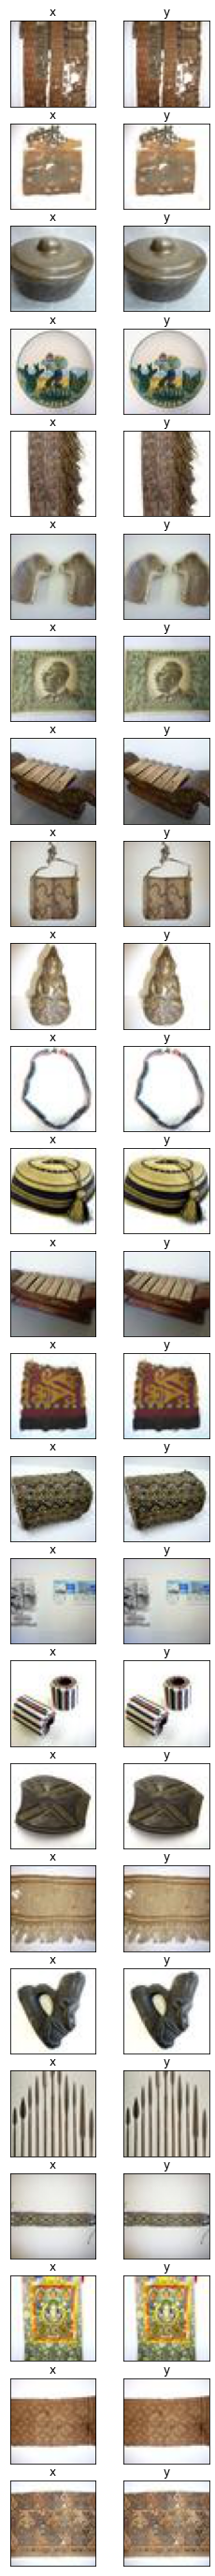

In [10]:
from matplotlib import pyplot as plt

show.show_and_compare_batch(batch)


Das Modell ist Quatsch, wir verwenden es nur, um die Funktion des Generators zu prüfen:

In [15]:
import numpy as np

from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

shape = (48, 48, 3)

input_layer = Input(shape=shape)

x = Flatten()(input_layer)

x = Dense(units=6912, activation='sigmoid')(x)

output_layer = Reshape(shape)(x)

model = Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 6912)              0         
_________________________________________________________________
dense (Dense)                (None, 6912)              47782656  
_________________________________________________________________
reshape (Reshape)            (None, 48, 48, 3)         0         
Total params: 47,782,656
Trainable params: 47,782,656
Non-trainable params: 0
_________________________________________________________________


In [17]:
optimizer = Adam(learning_rate=0.0005)

def loss(y_true, y_pred):
  return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

model.compile(loss=loss, optimizer=optimizer)

In [18]:
model.fit(train_gen, epochs=10)

Epoch 1/10
100/100 [==============================] - 26s 252ms/step - loss: 0.0490


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fac21cdb290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 2/10
 16/100 [===>..........................] - ETA: 21s - loss: 0.0302

KeyboardInterrupt: ignored

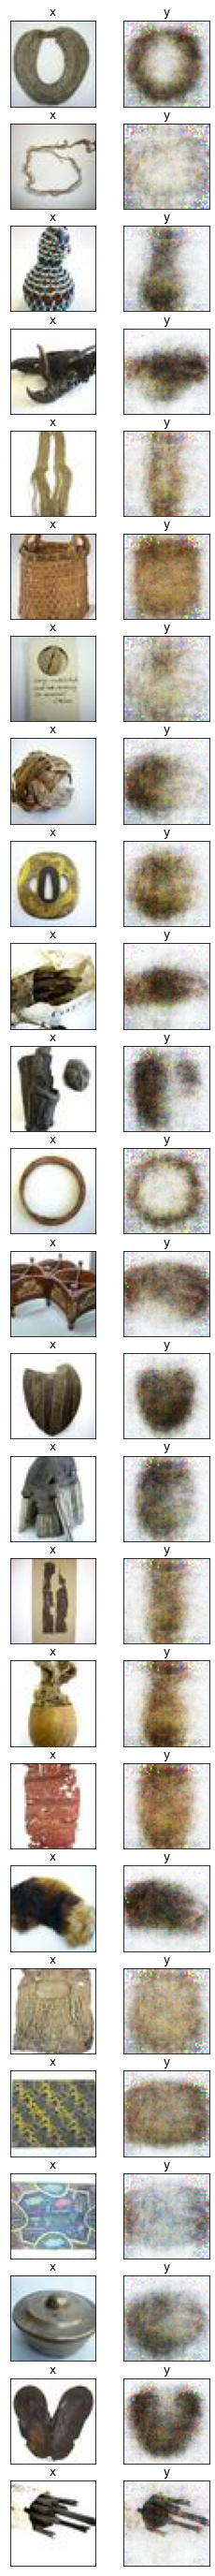

In [22]:
x = train_gen[3][0]
y = model.predict(x)

show.show_and_compare_batch([x,y])